* This notebook performs data cleaning, chunked summarization, and evaluation
* On the MTSamples dataset using BART-based transformer models.

In [1]:
# Install and Import Dependencies
!pip install -q pandas transformers nltk datasets evaluate rouge_score bert_score

In [2]:
# Import Libraries
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
import torch
import evaluate
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import display

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lapto\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Load Dataset
df = pd.read_csv("mtsamples.csv")
print("Original record count:", len(df))
print("Missing values per column:\n", df.isnull().sum())

Original record count: 4999
Missing values per column:
 Unnamed: 0              0
description             0
medical_specialty       0
sample_name             0
transcription          33
keywords             1068
dtype: int64


In [4]:
# Data Cleaning
def clean_text(text):
    text = text.replace('\n', ' ').replace('\r', ' ')
    text = ' '.join(text.split())
    return text.strip()

def preprocess_data(df):
    df = df.dropna(subset=['transcription', 'description']).copy()
    df['cleaned_transcription'] = df['transcription'].astype(str).apply(clean_text)
    return df

df_cleaned = preprocess_data(df)
print("Cleaned record count:", len(df_cleaned))
print(df_cleaned[['description', 'cleaned_transcription']].head(3))


Cleaned record count: 4966
                                         description  \
0   A 23-year-old white female presents with comp...   
1           Consult for laparoscopic gastric bypass.   
2           Consult for laparoscopic gastric bypass.   

                               cleaned_transcription  
0  SUBJECTIVE:, This 23-year-old white female pre...  
1  PAST MEDICAL HISTORY:, He has difficulty climb...  
2  HISTORY OF PRESENT ILLNESS: , I have seen ABC ...  


In [5]:
# Load Summarization Model
MODEL_NAME = "sshleifer/distilbart-cnn-12-6"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)
device = 0 if torch.cuda.is_available() else -1
summarizer = pipeline("summarization", model=model, tokenizer=tokenizer, device=device)

Device set to use cpu


In [6]:
# Text Chuncking
MAX_INPUT_LENGTH = 1024
CHUNK_OVERLAP = 200

def chunk_text(text, tokenizer, max_length=MAX_INPUT_LENGTH, overlap=CHUNK_OVERLAP):
    tokens = tokenizer.encode(text, add_special_tokens=True)
    chunks = []
    start = 0
    while start < len(tokens):
        end = min(start + max_length, len(tokens))
        chunk = tokenizer.decode(tokens[start:end], skip_special_tokens=True)
        chunks.append(chunk)
        start += max_length - overlap
    return chunks

In [7]:
# Summarization Function
SUMMARY_MAX = 150
SUMMARY_MIN = 40

def generate_medical_summary(text):
    if not text.strip():
        return ""
    input_len = len(tokenizer.encode(text))
    if input_len < MAX_INPUT_LENGTH:
        try:
            max_len = min(SUMMARY_MAX, input_len)
            return summarizer(text, max_length=max_len, min_length=SUMMARY_MIN, do_sample=False)[0]['summary_text']
        except Exception as e:
            print("Single-pass error:", e)
            return ""
    summaries = []
    for chunk in chunk_text(text, tokenizer):
        try:
            input_len = len(tokenizer.encode(chunk))
            max_len = min(SUMMARY_MAX, input_len)
            summary = summarizer(chunk, max_length=max_len, min_length=SUMMARY_MIN, do_sample=False)[0]['summary_text']
            summaries.append(summary)
        except Exception as e:
            print("Chunk error:", e)
            continue
    return summarizer(" ".join(summaries), max_length=SUMMARY_MAX*2, min_length=SUMMARY_MIN*2, do_sample=False)[0]['summary_text']


In [8]:
# Batch Summarization of 30 Reports
df_batch = df_cleaned.head(30).copy()
summaries = []
print("\nGenerating summaries for 30 reports...")
for i, text in tqdm(enumerate(df_batch['cleaned_transcription']), total=30):
    print(f"Summarizing index {i}...")
    summaries.append(generate_medical_summary(text))
df_batch['generated_summary'] = summaries
df_batch.to_csv("batch_30_summaries.csv", index=False)
print("Saved to 'batch_30_summaries.csv'")


Generating summaries for 30 reports...


  0%|          | 0/30 [00:00<?, ?it/s]

Summarizing index 0...
Summarizing index 1...


Token indices sequence length is longer than the specified maximum sequence length for this model (1082 > 1024). Running this sequence through the model will result in indexing errors


Summarizing index 2...
Chunk error: index out of range in self


Your max_length is set to 300, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


Summarizing index 3...
Summarizing index 4...
Summarizing index 5...
Chunk error: index out of range in self


Your max_length is set to 300, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Summarizing index 6...
Summarizing index 7...
Summarizing index 8...
Summarizing index 9...
Summarizing index 10...
Summarizing index 11...
Summarizing index 12...
Summarizing index 13...
Summarizing index 14...
Summarizing index 15...
Summarizing index 16...
Chunk error: index out of range in self


Your max_length is set to 300, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


Summarizing index 17...
Summarizing index 18...
Summarizing index 19...
Summarizing index 20...
Summarizing index 21...
Summarizing index 22...
Summarizing index 23...


Your min_length=40 must be inferior than your max_length=9.


Summarizing index 24...


c:\Users\lapto\anaconda3\Lib\site-packages\transformers\generation\utils.py:1633: UserWarning: Unfeasible length constraints: `min_length` (40) is larger than the maximum possible length (9). Generation will stop at the defined maximum length. You should decrease the minimum length and/or increase the maximum length.
  warnings.warn(


Summarizing index 25...
Summarizing index 26...
Summarizing index 27...
Summarizing index 28...
Summarizing index 29...
Saved to 'batch_30_summaries.csv'


In [9]:
# Display all 30 descriptions and their generated summaries
df_batch[['description', 'generated_summary']].head(30)

,description,generated_summary
0,A 23-year-old white female presents with comp...,23-year-old white female presents with compla...
1,Consult for laparoscopic gastric bypass.,"He has difficulty climbing stairs, difficulty..."
2,Consult for laparoscopic gastric bypass.,He wants to proceed with workup and evaluatio...
3,2-D M-Mode. Doppler.,Left atrial enlargement with left atrial diam...
4,2-D Echocardiogram,Left ventricular cavity size and wall thickne...
5,Morbid obesity. Laparoscopic antecolic anteg...,The patient tolerated the procedure well with...
6,"Liposuction of the supraumbilical abdomen, re...","Deformity, right breast reconstruction . Exce..."
7,2-D Echocardiogram,Cardiac function is normal . There is no sign...
8,Suction-assisted lipectomy - lipodystrophy of...,The patient tolerated the procedure very well...
9,Echocardiogram and Doppler,Aortic valve seen with good motion . Mitral a...


In [10]:
# Evaluation (ROUGE + BERTScore)
rouge = evaluate.load('rouge')
bertscore = evaluate.load('bertscore')

refs = df_batch['description'].tolist()
preds = df_batch['generated_summary'].tolist()
valid = [(p, r) for p, r in zip(preds, refs) if p and r]

if valid:
    preds_valid, refs_valid = zip(*valid)
    rouge_results = rouge.compute(predictions=preds_valid, references=refs_valid)
    bert_results = bertscore.compute(predictions=preds_valid, references=refs_valid, model_type="bert-base-uncased")
    print("\n ROUGE:", rouge_results)
    print("BERTScore F1 (mean):", sum(bert_results['f1']) / len(bert_results['f1']))
    pd.DataFrame([{
        "rouge1": rouge_results['rouge1'],
        "rouge2": rouge_results['rouge2'],
        "rougeL": rouge_results['rougeL'],
        "bertscore_f1": sum(bert_results['f1']) / len(bert_results['f1'])
    }]).to_csv("evaluation_metrics.csv", index=False)
else:
    print("No valid references/predictions to evaluate.")


 ROUGE: {'rouge1': np.float64(0.23768723795304114), 'rouge2': np.float64(0.1810573108083268), 'rougeL': np.float64(0.2193536853284897), 'rougeLsum': np.float64(0.21752305535809036)}
BERTScore F1 (mean): 0.5542918980121613


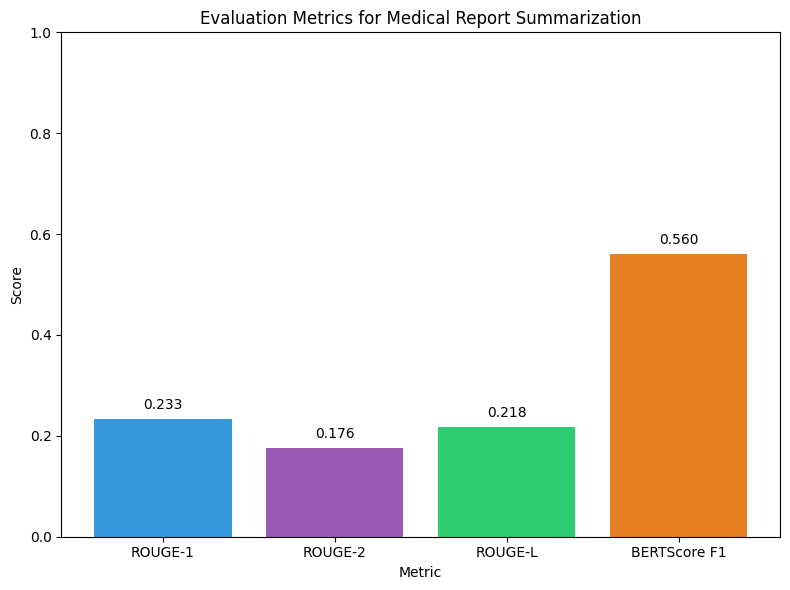

In [11]:
# Evaluation Matrix Result

# Evaluation results
metrics = {
    "ROUGE-1": 0.2328,
    "ROUGE-2": 0.1759,
    "ROUGE-L": 0.2176,
    "BERTScore F1": 0.5597
}

# Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(metrics.keys(), metrics.values(), color=["#3498db", "#9b59b6", "#2ecc71", "#e67e22"])
plt.ylim(0, 1)
plt.title("Evaluation Metrics for Medical Report Summarization")
plt.ylabel("Score")
plt.xlabel("Metric")

# Annotate bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.3f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [12]:
def generate_medical_summary(text, age=None, gender=None, allergies=None, diagnosis=None, medications=None):
    if not text.strip():
        return ""

    # Normalize and validate gender
    if gender:
        gender = gender.lower()
        if gender not in ["male", "female", "other"]:
            gender = "unspecified"

    # Build demographic + clinical context
    demographics = []
    if gender: demographics.append(f"{gender}")
    if age: demographics.append(f"{age}-year-old")
    demographic_info = " ".join(demographics)

    structured_info = []
    if diagnosis: structured_info.append(f"Diagnosis: {diagnosis}")
    if medications: structured_info.append(f"Medications: {medications}")
    if allergies: structured_info.append(f"Allergies: {allergies}")

    # Final prompt construction
    preamble = f"Patient is a {demographic_info}."
    if structured_info:
        preamble += " " + " ".join(structured_info)
    prompt = f"{preamble}\nSummarize the following medical report:\n{text}"

    # Token limit check
    input_len = len(tokenizer.encode(prompt))
    if input_len < MAX_INPUT_LENGTH:
        return summarizer(prompt, max_length=SUMMARY_MAX, min_length=SUMMARY_MIN, do_sample=False)[0]['summary_text']

    # Chunking with context
    summaries = []
    for chunk in chunk_text(text, tokenizer):
        chunk_prompt = f"{preamble}\n{chunk}"
        summary = summarizer(chunk_prompt, max_length=SUMMARY_MAX, min_length=SUMMARY_MIN, do_sample=False)[0]['summary_text']
        summaries.append(summary)

    # Combine and summarize
    final_summary = summarizer(" ".join(summaries), max_length=SUMMARY_MAX*2, min_length=SUMMARY_MIN*2, do_sample=False)[0]['summary_text']
    return final_summary


In [13]:
# Original Medical Report vs Summary
text = df_cleaned.iloc[0]['cleaned_transcription']
summary = generate_medical_summary(text, age="23", gender="female")

print("\n Original Report:\n", text[:1000], "...\n")  # Limit to 1000 chars for readability
print(" Generated Summary:\n", summary)


 Original Report:
 SUBJECTIVE:, This 23-year-old white female presents with complaint of allergies. She used to have allergies when she lived in Seattle but she thinks they are worse here. In the past, she has tried Claritin, and Zyrtec. Both worked for short time but then seemed to lose effectiveness. She has used Allegra also. She used that last summer and she began using it again two weeks ago. It does not appear to be working very well. She has used over-the-counter sprays but no prescription nasal sprays. She does have asthma but doest not require daily medication for this and does not think it is flaring up.,MEDICATIONS: , Her only medication currently is Ortho Tri-Cyclen and the Allegra.,ALLERGIES: , She has no known medicine allergies.,OBJECTIVE:,Vitals: Weight was 130 pounds and blood pressure 124/78.,HEENT: Her throat was mildly erythematous without exudate. Nasal mucosa was erythematous and swollen. Only clear drainage was seen. TMs were clear.,Neck: Supple without adenopat

In [14]:
def generate_medical_summary(text, age=None, gender=None):
    if not text.strip():
        return ""

    # Better demographic prompt integration
    if age and gender:
        prompt = f"Summarize the following medical report written for a {gender} aged {age}:\n{text}"
    else:
        prompt = f"Summarize the following medical report:\n{text}"

    try:
        input_ids = tokenizer.encode(prompt, truncation=False)
    except Exception as e:
        print("Encoding error:", e)
        return ""

    if len(input_ids) < MAX_INPUT_LENGTH:
        try:
            return summarizer(prompt, max_length=min(SUMMARY_MAX, len(input_ids)), min_length=SUMMARY_MIN, do_sample=False)[0]['summary_text']
        except Exception as e:
            print("Single pass error:", e)
            return ""

    summaries = []
    for chunk in chunk_text(text, tokenizer):
        try:
            if age and gender:
                chunk_prompt = f"Summarize this report for a {gender} aged {age}:\n{chunk}"
            else:
                chunk_prompt = f"Summarize this medical report:\n{chunk}"
            summary = summarizer(chunk_prompt, max_length=SUMMARY_MAX, min_length=SUMMARY_MIN, do_sample=False)[0]['summary_text']
            summaries.append(summary)
        except Exception as e:
            print("Chunk error:", e)
            continue

    try:
        final_prompt = " ".join(summaries)
        return summarizer(final_prompt, max_length=SUMMARY_MAX*2, min_length=SUMMARY_MIN*2, do_sample=False)[0]['summary_text']
    except Exception as e:
        print("Final pass error:", e)
        return " ".join(summaries)


In [15]:
#  Comparison Table for Multiple Records
# To evaluate or showcase the summarization pipeline across multiple samples.
df_display = df_cleaned.head(30).copy()
df_display['generated_summary'] = df_display['cleaned_transcription'].apply(
    lambda x: generate_medical_summary(x, age="50", gender="female")
)
display(df_display[['description', 'cleaned_transcription', 'generated_summary']])


Chunk error: index out of range in self


Your max_length is set to 300, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Chunk error: index out of range in self


Your max_length is set to 300, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Chunk error: index out of range in self


Your max_length is set to 300, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your min_length=40 must be inferior than your max_length=24.
c:\Users\lapto\anaconda3\Lib\site-packages\transformers\generation\utils.py:1633: UserWarning: Unfeasible length constraints: `min_length` (40) is larger than the maximum possible length (24). Generation will stop at the defined maximum length. You should decrease the minimum length and/or increase the maximum length.
  warnings.warn(


,description,cleaned_transcription,generated_summary
0,A 23-year-old white female presents with comp...,"SUBJECTIVE:, This 23-year-old white female pre...",Allergies are worse in Seattle than they were...
1,Consult for laparoscopic gastric bypass.,"PAST MEDICAL HISTORY:, He has difficulty climb...","He has difficulty climbing stairs, difficulty..."
2,Consult for laparoscopic gastric bypass.,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...",He wants to proceed with workup and evaluatio...
3,2-D M-Mode. Doppler.,"2-D M-MODE: , ,1. Left atrial enlargement with...",Left atrial enlargement with left atrial diam...
4,2-D Echocardiogram,1. The left ventricular cavity size and wall t...,The left ventricular cavity size and wall thi...
5,Morbid obesity. Laparoscopic antecolic anteg...,"PREOPERATIVE DIAGNOSIS: , Morbid obesity.,POST...",The patient tolerated the procedure well with...
6,"Liposuction of the supraumbilical abdomen, re...","PREOPERATIVE DIAGNOSES:,1. Deformity, right br...","Deformity, right breast reconstruction., Exce..."
7,2-D Echocardiogram,"2-D ECHOCARDIOGRAM,Multiple views of the heart...",Cardiac function is normal . There is no sign...
8,Suction-assisted lipectomy - lipodystrophy of...,"PREOPERATIVE DIAGNOSIS: , Lipodystrophy of the...",The patient tolerated the procedure very well...
9,Echocardiogram and Doppler,"DESCRIPTION:,1. Normal cardiac chambers size.,...","Aortic valve seen with good motion., Mitral v..."
